In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: syedosamaalishah092
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset


100%|██████████| 7.40G/7.40G [07:04<00:00, 18.7MB/s]


In [4]:
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, applications
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/militaryaircraftdetectiondataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/militaryaircraftdetectiondataset/crop/F18/d3e17196548f36c634e52e1fa48b5812_7.jpg
/content/militaryaircraftdetectiondataset/crop/F18/33dba7435590767eb23ca29ad654ccc0_0.jpg
/content/militaryaircraftdetectiondataset/crop/F18/ff99ce285c163e3a67f03f9f8ee90761_0.jpg
/content/militaryaircraftdetectiondataset/crop/F18/e39477f6cef38bb21f379ea66abcc796_6.jpg
/content/militaryaircraftdetectiondataset/crop/F18/b1ec2eccb3475a84012b7e49b4979682_2.jpg
/content/militaryaircraftdetectiondataset/crop/F18/c7d5814653a57d10d34228ccba0baed2_3.jpg
/content/militaryaircraftdetectiondataset/crop/F18/3368a38e6f339cfd9f30521cde4a9461_5.jpg
/content/militaryaircraftdetectiondataset/crop/F18/158eda61c55ccd99543b11e826633d1a_0.jpg
/content/militaryaircraftdetectiondataset/crop/F18/87b0a668bede7af9da3ddd84cfee51c8_17.jpg
/content/militaryaircraftdetectiondataset/crop/F18/8edf20a09a4d67c8962b3bd5af24ec60_4.jpg
/content/militaryaircraftdetectiondataset/crop/F

In [5]:
path = "/content/militaryaircraftdetectiondataset/crop/"
data_dir = pathlib.Path(path)

In [6]:
SEED = 123
image_size = (224, 224)
BATCH_SIZE = 32

In [7]:
train_data = image_dataset_from_directory(data_dir,
                                          validation_split=0.3,
                                          subset='training',
                                          seed=SEED,
                                          shuffle=True,
                                          image_size=image_size,
                                          batch_size=BATCH_SIZE
                                          )

Found 25598 files belonging to 53 classes.
Using 17919 files for training.


In [8]:
class_names = train_data.class_names

In [9]:
validation_data = image_dataset_from_directory(data_dir,
                                               validation_split=0.3,
                                               subset='validation',
                                               seed=SEED,
                                               image_size=image_size,
                                               batch_size=BATCH_SIZE)

Found 25598 files belonging to 53 classes.
Using 7679 files for validation.


In [10]:
val_batches = tf.data.experimental.cardinality(validation_data)
test_data = validation_data.take(val_batches//5)
val_data = validation_data.skip(val_batches//5)

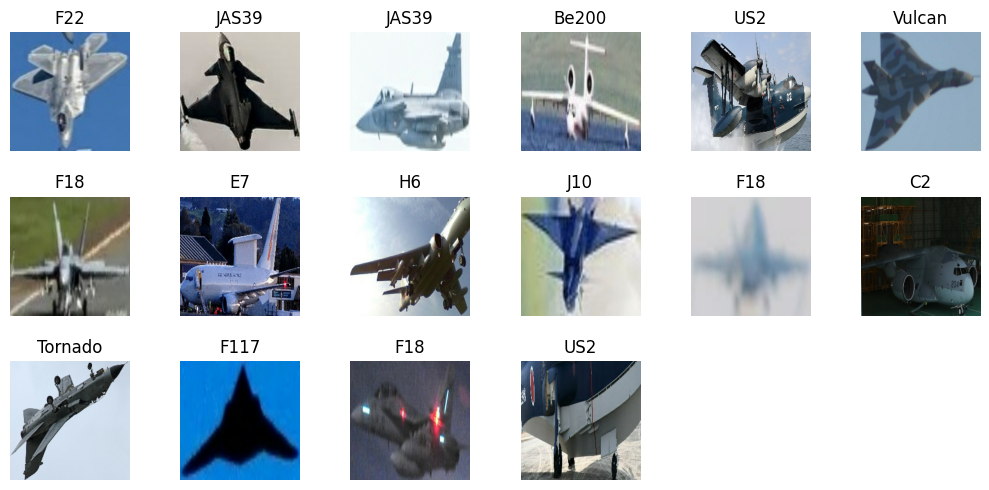

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(16):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.tight_layout()
        plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal'))
data_augmentation.add(layers.RandomRotation(0.10))
data_augmentation.add(layers.RandomZoom(0.01, 0.01))

In [14]:
base_model = tf.keras.applications.EfficientNetB6(weights='imagenet', include_top=False, input_shape=image_size+(3,))

base_model.trainable = False

preprocess_input = tf.keras.applications.efficientnet.preprocess_input

165234480/165234480 [==============================] - 8s 0us/step


In [15]:
inputs = layers.Input(shape=image_size + (3,))


x = data_augmentation(inputs)

x = layers.Lambda(preprocess_input)(x)

x = base_model(x)

x = layers.GlobalAveragePooling2D()(x)

#x = layers.Dense(128, activation='relu')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='relu')(x)
x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.2)(x)


# Add output layer
outputs = layers.Dense(len(class_names), activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10,min_delta=0.001, verbose=1)

In [18]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=8,min_lr=0.001, verbose=1)

In [ ]:
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[lr_reducer, early_stopping],verbose=1)

Epoch 1/50
560/560 [==============================] - 157s 240ms/step - loss: 3.2450 - accuracy: 0.1981 - val_loss: 2.6691 - val_accuracy: 0.3059 - lr: 0.0010
Epoch 2/50
560/560 [==============================] - 131s 233ms/step - loss: 2.5135 - accuracy: 0.3462 - val_loss: 2.3151 - val_accuracy: 0.3734 - lr: 0.0010
Epoch 3/50
560/560 [==============================] - 131s 233ms/step - loss: 2.2126 - accuracy: 0.4133 - val_loss: 2.1624 - val_accuracy: 0.4097 - lr: 0.0010
Epoch 4/50
560/560 [==============================] - 131s 233ms/step - loss: 2.0216 - accuracy: 0.4613 - val_loss: 2.0410 - val_accuracy: 0.4527 - lr: 0.0010
Epoch 5/50
560/560 [==============================] - 131s 233ms/step - loss: 1.9150 - accuracy: 0.4833 - val_loss: 1.9742 - val_accuracy: 0.4692 - lr: 0.0010
Epoch 6/50
560/560 [==============================] - 131s 233ms/step - loss: 1.8149 - accuracy: 0.5103 - val_loss: 1.8959 - val_accuracy: 0.4931 - lr: 0.0010
Epoch 7/50
560/560 [==========================

KeyboardInterrupt: 

In [ ]:
base_model2 = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=image_size+(3,))

base_model2.trainable = False

preprocess_input2 = tf.keras.applications.efficientnet_v2.preprocess_input

In [ ]:
inputs = layers.Input(shape=image_size + (3,))

x = data_augmentation(inputs)
x = layers.Lambda(preprocess_input2)(x)
x = base_model2(x)
x = layers.GlobalAveragePooling2D()(x)


x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)


# Add output layer
outputs = layers.Dense(len(class_names), activation='softmax')(x)

# Create the model
model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[lr_reducer, early_stopping],verbose=1)